In [1]:
import tensorflow as tf
import os
import numpy as np
from keras.utils import np_utils
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
n_epoch = 3000
batch_size = 64
h_dim = 128
z_dim = 100
n_sample = mnist.train.images.shape[0]

In [5]:
def flatten(x):
    out_dim = np.prod(x.get_shape()[1:].as_list())
    return tf.reshape(x, shape=(-1, out_dim))

def weight(shape):
    with tf.variable_scope('weight'):
        return tf.get_variable('weight', shape, initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)

def bias(shape):
    with tf.variable_scope('bias'):
        init = np.ones(shape, dtype=np.float32) * 0.1
        return tf.get_variable('bias', initializer=init, dtype=tf.float32)

def fc_layer(x, unit, tag=None, name=None, activation=None):
    with tf.variable_scope(name):
        in_dim = int(x.get_shape()[-1])
        out_dim = unit
        w = weight([in_dim, out_dim])
        b = bias([out_dim])
        if tag:
            tf.add_to_collection(name=tag, value=w)
            tf.add_to_collection(name=tag, value=b)
        out = tf.matmul(x, w) + b
        return activation(out) if activation else out
    
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    
def save_image(G, epoch, n_imgs=20, img_size=(128, 128)):
    if not os.path.exists('out/epoch_{0}'.format(epoch)):
        os.mkdir('out/epoch_{0}'.format(epoch))

    imgs = G.eval(feed_dict={zs:sampler((n_imgs, z_dim))})
    for step, img in enumerate(imgs):
        img = deprocess_image(np.squeeze(img))
        img = Image.fromarray(img)
        img.resize(img_size).save('out/epoch_{0}/{1}.png'.format(epoch, step))
        
def show_image(G, n_imgs=5):
    for step in range(n_imgs):
        plt.figure()
        img = G.eval(feed_dict={zs:sampler((1, z_dim))})
        img = deprocess_image(np.squeeze(img))
        plt.imshow(img, cmap='Greys_r')
        plt.show()

In [6]:
def discriminator(x, name, reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        tag = 'D' if reuse else None
        x = flatten(x)
        x = fc_layer(x, 128, activation=tf.nn.relu, name='d_fc1', tag=tag)
        #x = fc_layer(x, 128, activation=tf.nn.relu, name='d_fc2', tag=tag)
        x = fc_layer(x, 1, name='d_fc3', tag=tag)

        return tf.nn.sigmoid(x), x

def generator(z, name):
    with tf.variable_scope(name):
        x = fc_layer(z, 128, activation=tf.nn.relu, name='g_fc1', tag='G')
        #x = fc_layer(x, 128, activation=tf.nn.relu, name='g_fc2', tag='G')
        x = fc_layer(x, 784, activation=tf.nn.sigmoid, name='g_fc3', tag='G')

        return tf.reshape(x, [-1, 28, 28, 1])



In [7]:
def sampler(shape, method='unif'):
    if method == 'unif':
        return np.random.uniform(-1., 1., size=shape)
    return np.random.random(shape)

In [8]:
import matplotlib.gridspec as gridspec
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
xs = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='input')
ys = tf.placeholder(tf.float32, shape=(None, 10), name='label')
zs = tf.placeholder(tf.float32, shape=[None, z_dim], name='noise')

G = generator(zs, name='generator')
D_real, D_logit = discriminator(xs, name='discriminator')
D_fake, _D_logit = discriminator(G, name='discriminator', reuse=True)


real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_logit), logits=D_logit))
fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(_D_logit), logits=_D_logit))

d_loss = real_loss + fake_loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(_D_logit), logits=_D_logit))
d_optim = tf.train.AdamOptimizer(2e-4).minimize(d_loss, var_list=tf.get_collection('D'))
g_optim = tf.train.AdamOptimizer(2e-4).minimize(g_loss, var_list=tf.get_collection('G'))

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

0.398369 1.75514


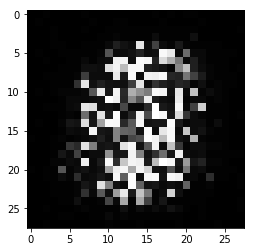

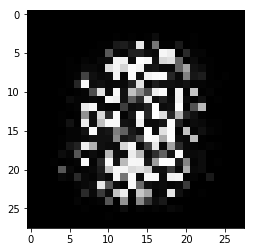

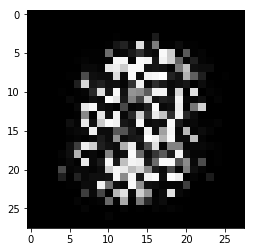

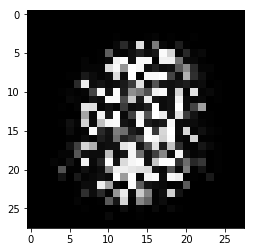

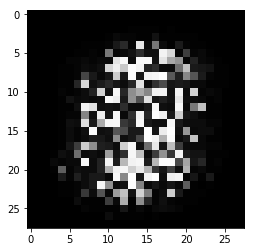

0.275762 2.71325
0.147128 3.12177
0.506669 2.11472
0.294487 2.31518
0.811552 1.80106


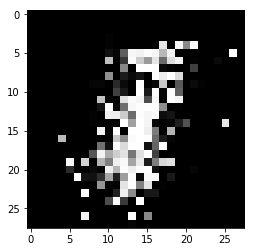

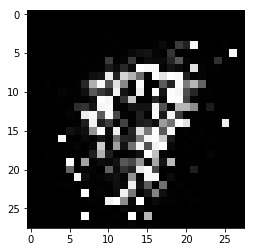

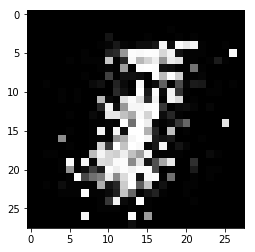

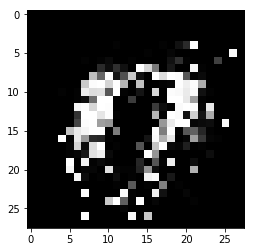

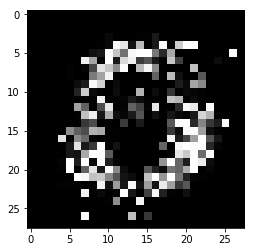

0.228774 2.54931
0.526177 2.06375
0.361268 2.52974
0.554282 2.26158
0.503749 2.18093


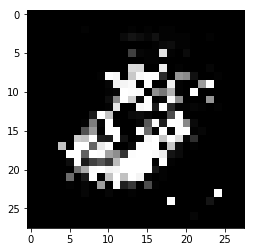

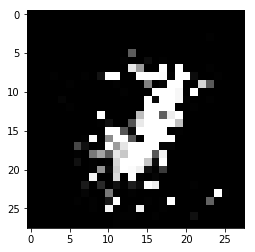

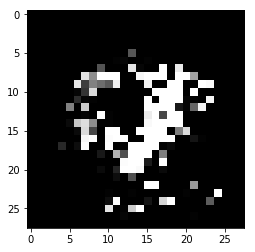

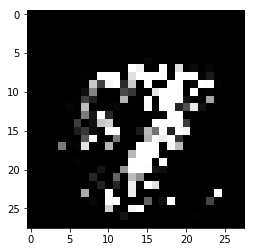

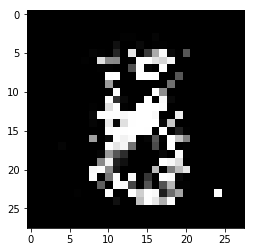

0.552066 2.51935
0.480826 2.90276
0.258056 3.00765
0.154198 3.7015
0.108091 4.07603


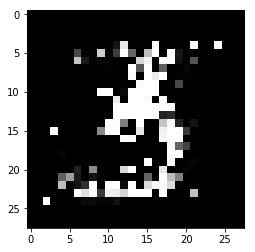

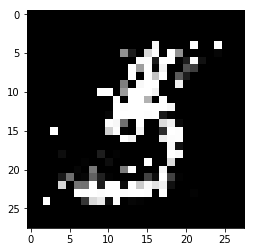

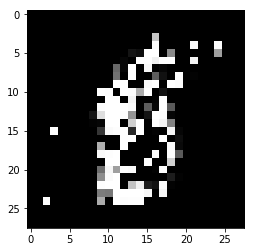

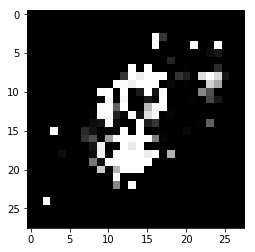

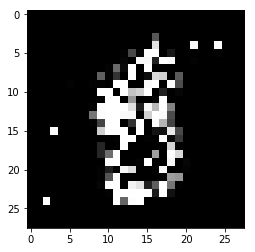

0.123512 3.08208
0.140925 3.89817
0.320223 3.61837
0.291294 3.30617
0.208667 3.15486


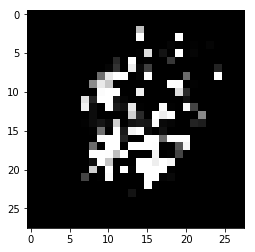

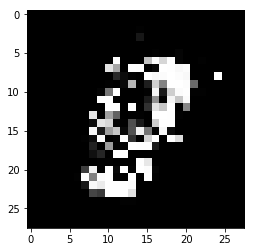

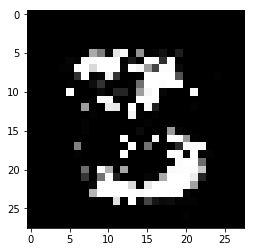

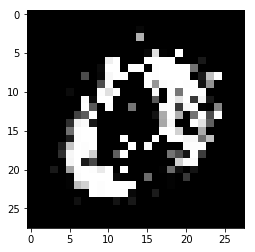

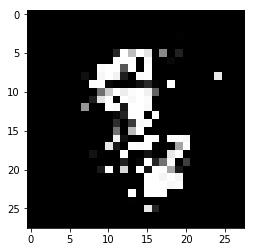

0.203069 3.75485
0.336453 2.93894
0.304961 3.58468
0.461532 3.11772
0.430238 2.91989


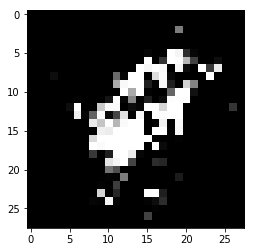

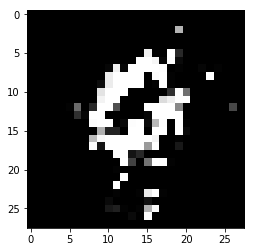

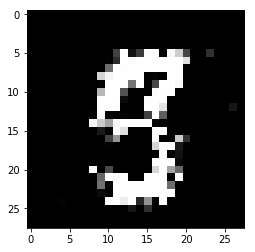

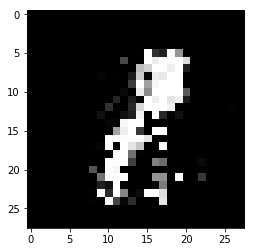

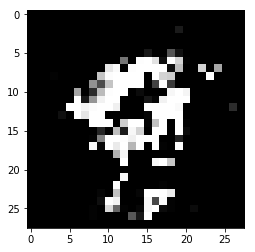

0.568406 2.76217
0.357167 2.73408
0.405673 2.75337
0.460291 2.74761
0.640512 2.74014


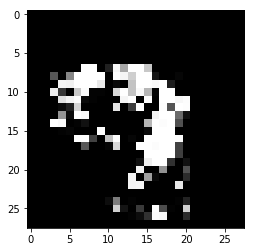

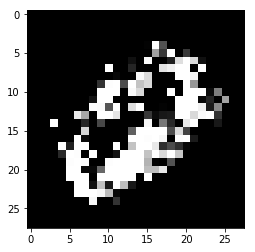

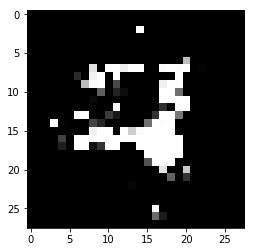

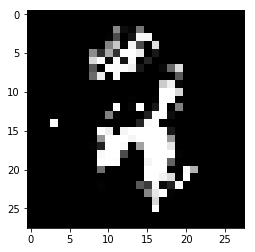

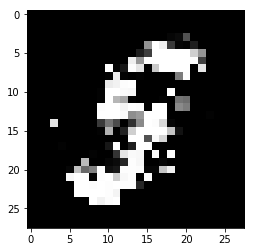

0.706154 2.47564
0.680497 2.84943
0.444097 2.59209
0.488695 2.78317
0.851074 2.31501


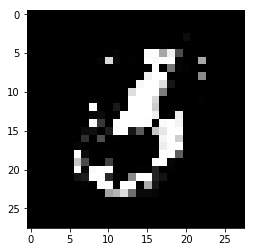

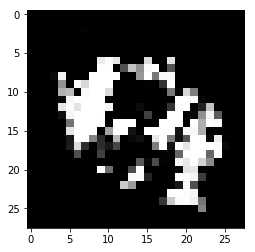

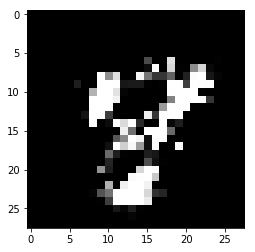

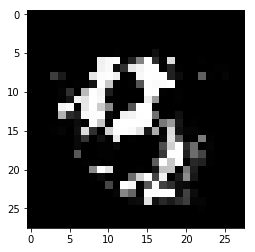

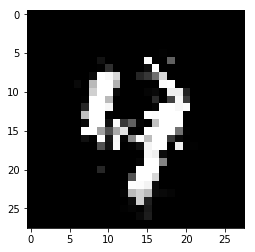

0.646293 2.29583
0.499322 2.87361
0.600578 2.45137
0.662955 2.35756
0.465361 2.39538


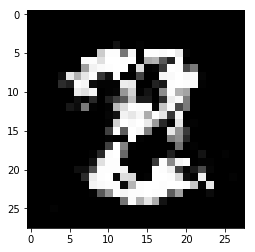

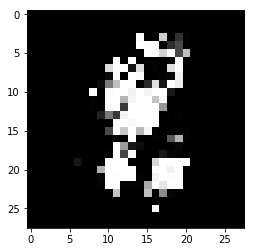

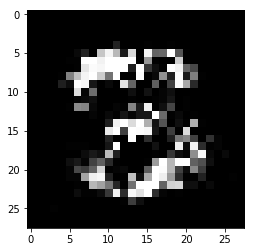

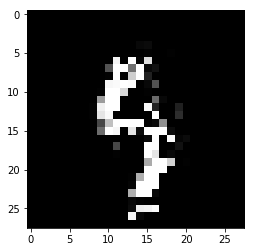

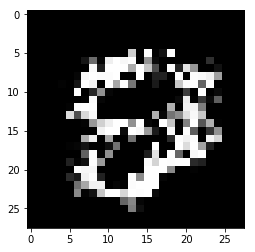

0.819928 2.17549
0.637872 2.30623
0.502044 2.51836
0.618396 2.30005
0.84284 2.21052


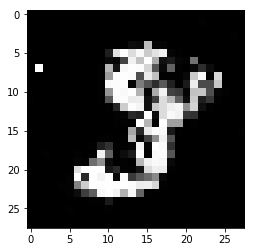

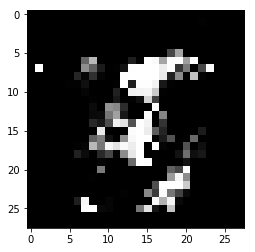

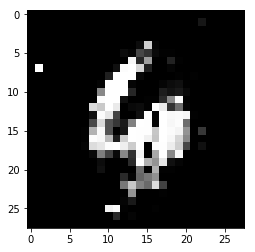

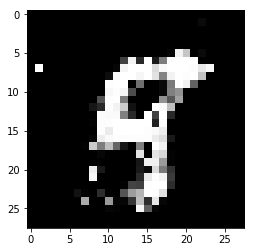

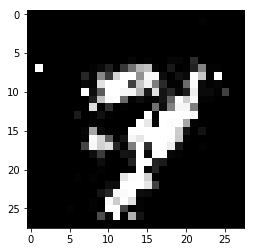

0.681679 2.20778
0.503956 2.52055
0.773136 2.14952
0.757921 2.08035
0.91555 1.7959


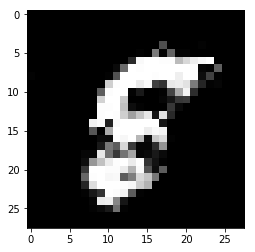

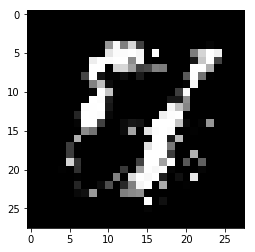

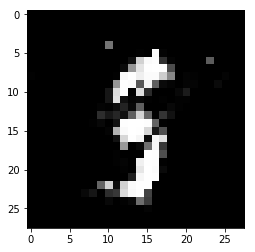

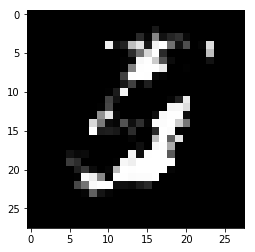

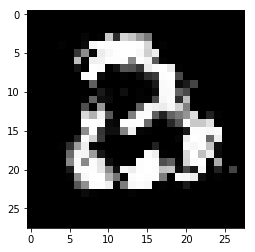

0.932465 1.8121
1.01173 1.98101
0.828734 2.06932
0.804949 1.59593
0.806132 1.84598


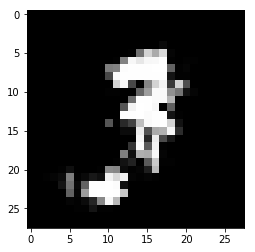

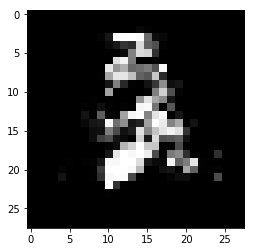

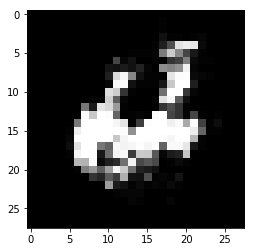

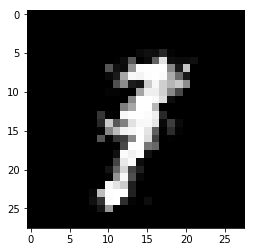

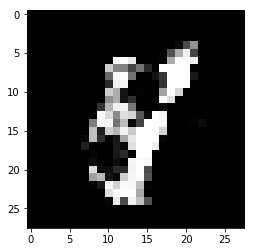

0.940804 1.79263
0.871643 1.69848
0.91547 1.92376
0.910217 1.69232
0.837449 1.86961


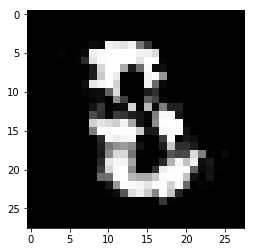

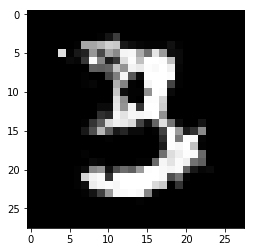

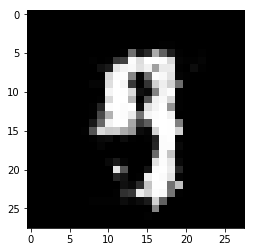

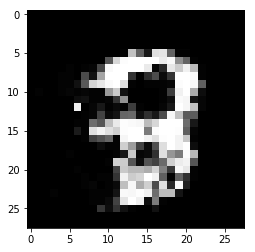

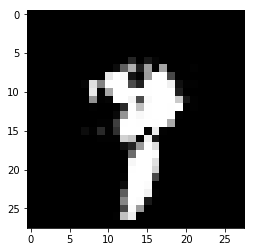

1.21861 1.67451
0.873116 1.7426
0.878091 1.78163
0.800811 1.96235
0.959518 1.55572


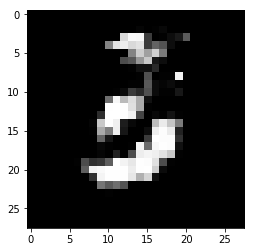

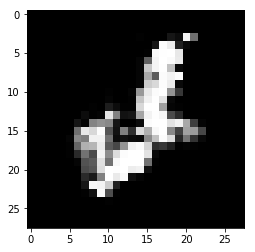

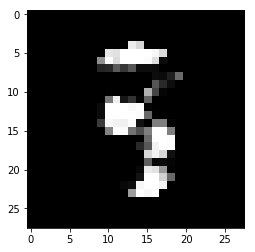

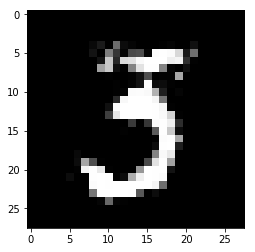

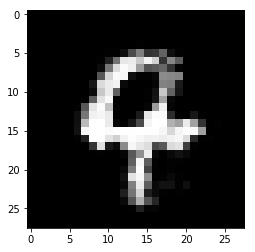

0.775286 1.69494
0.779178 1.83567
0.83933 1.76617
0.736905 1.61033
0.88628 1.41712


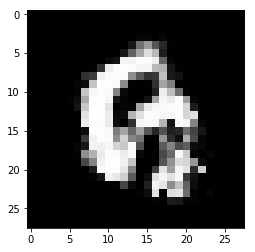

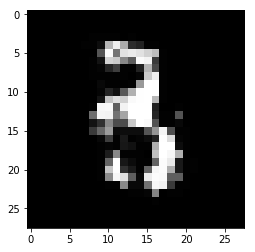

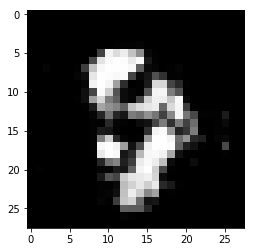

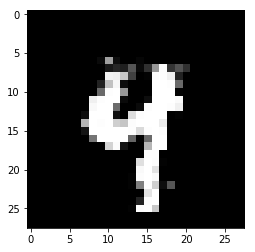

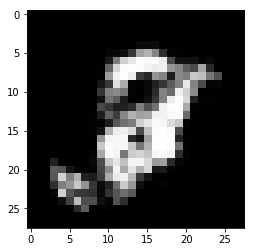

0.827569 1.79269
0.858559 1.68485
1.04722 1.48967
0.762459 1.69238
0.774441 1.58844


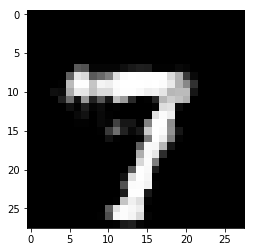

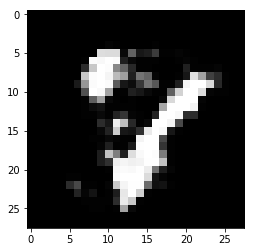

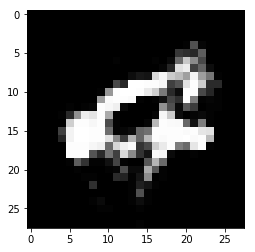

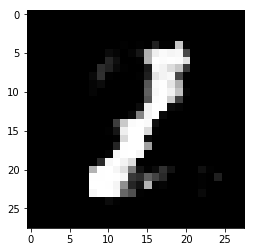

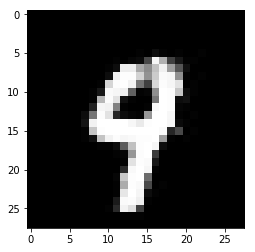

0.692314 1.80556
0.845121 1.6875
0.827564 1.78805
0.870581 1.79134
0.826055 1.81463


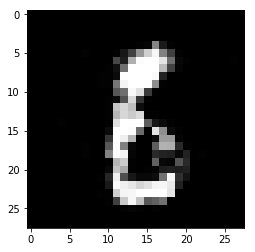

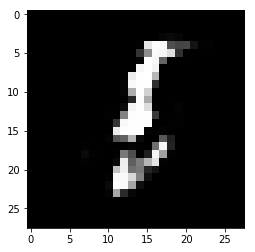

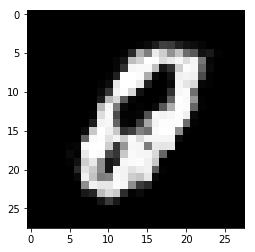

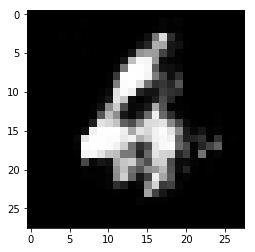

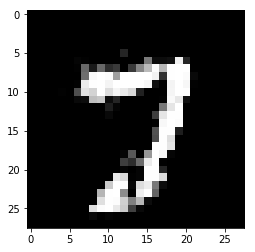

0.886535 1.55466
0.747663 1.83186
1.00277 1.71237
0.644158 1.53216
0.723017 1.70858


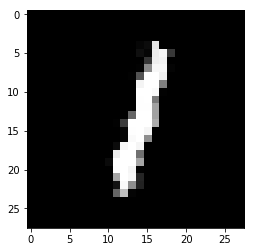

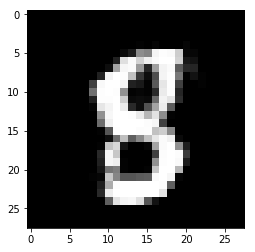

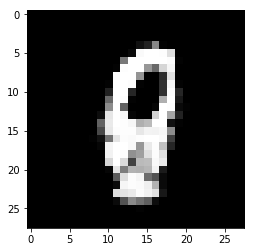

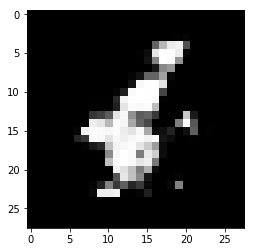

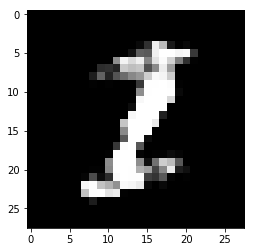

0.823427 1.70326
0.79873 1.73601
0.697648 1.66181
0.849336 1.78238
0.853873 1.64811


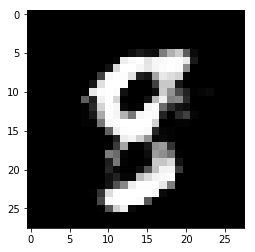

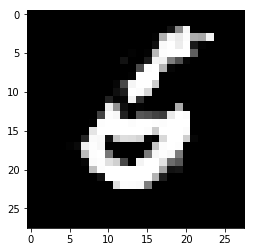

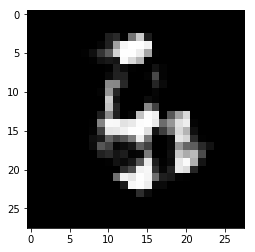

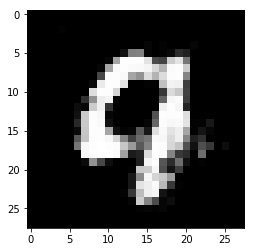

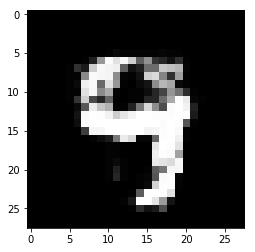

0.849808 1.50614
0.637368 1.9055
0.597827 2.08411
0.780085 1.72248
0.638918 1.60552


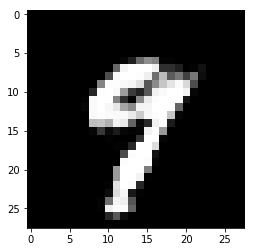

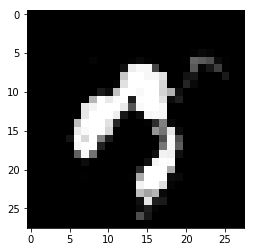

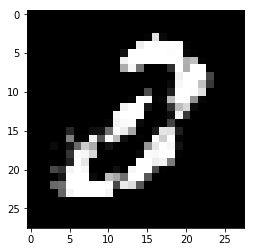

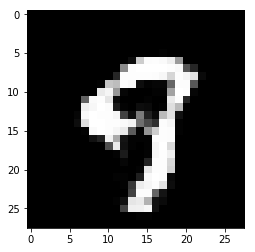

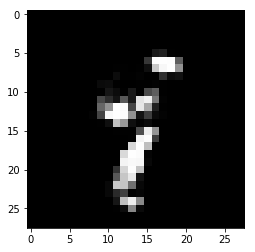

0.804896 1.99038
0.736975 1.73911
0.816867 1.90416
0.837773 1.63333
0.697601 1.57159


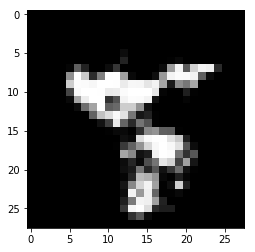

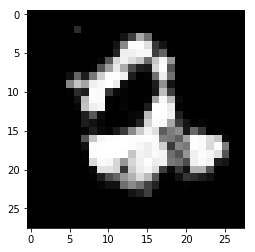

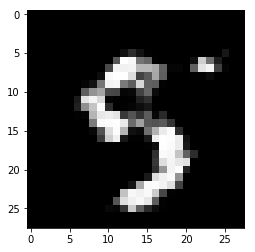

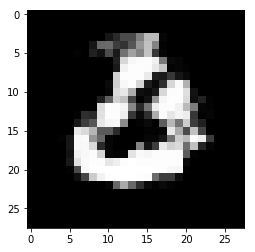

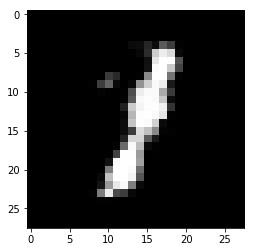

0.543395 2.20238
0.660606 2.08489
0.969556 1.47318
0.680206 1.96036
0.859867 1.94908


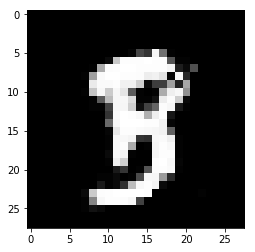

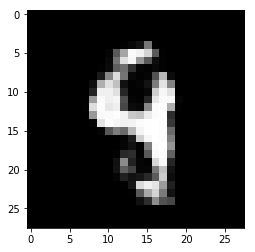

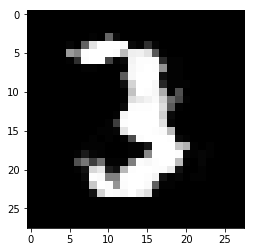

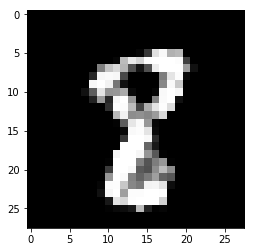

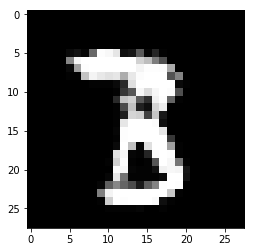

0.697336 1.79713
0.792774 1.96279
0.830023 2.13219
0.925612 1.77498
0.865651 1.8919


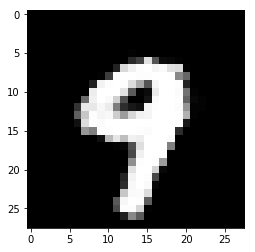

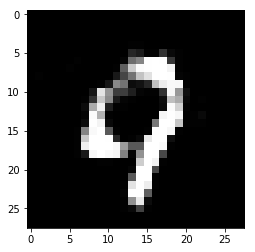

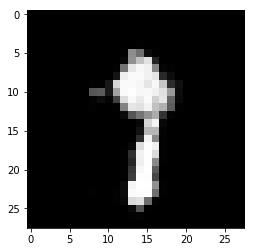

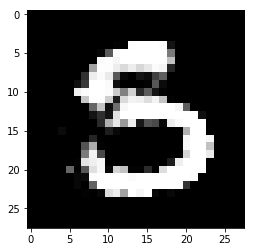

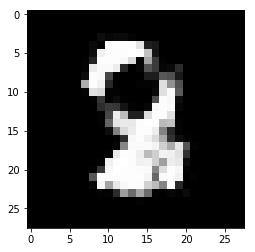

0.802575 1.91752
0.710263 2.05397
0.709004 1.95812
0.760971 1.91438
0.703053 2.00532


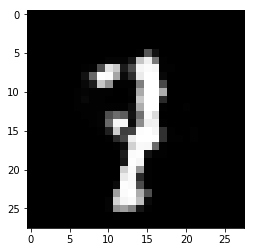

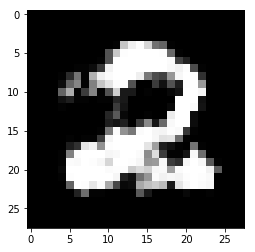

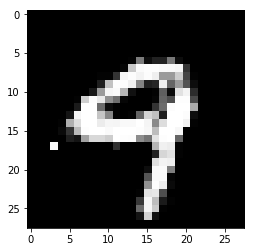

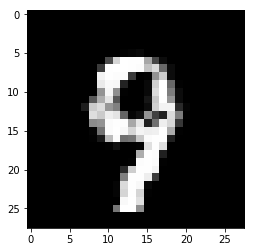

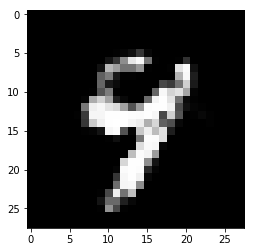

0.714188 1.99381
0.83668 1.86323
0.786276 2.07373
0.611705 2.18064
0.703149 2.21567


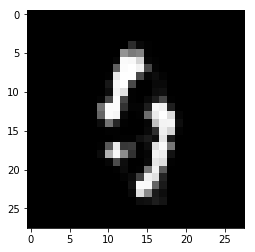

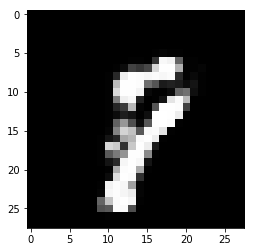

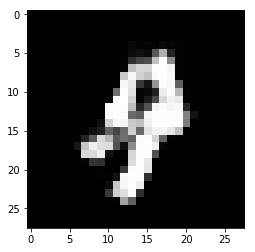

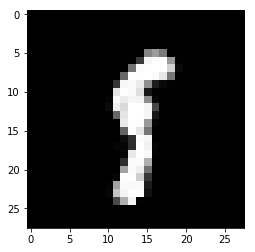

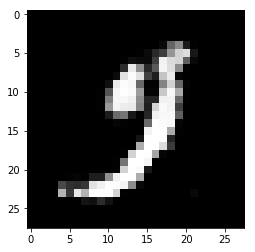

0.670538 2.12361
0.624758 2.3729
0.65192 2.03512
0.587432 2.22204
0.68756 1.8998


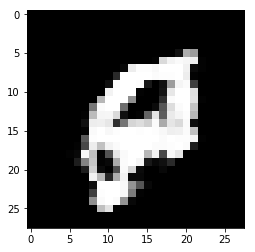

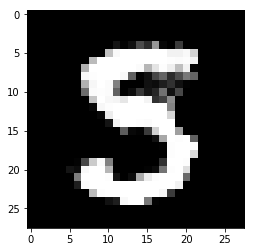

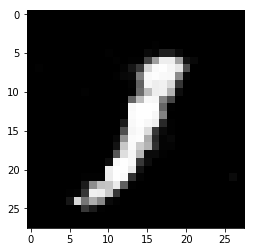

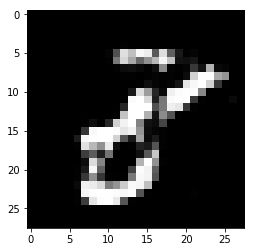

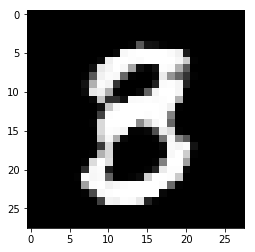

0.650802 2.0626
0.808869 1.84107
0.559486 1.96905
0.693565 1.89797
0.683542 2.11483


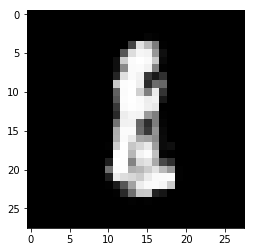

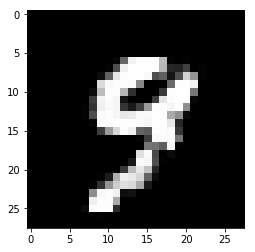

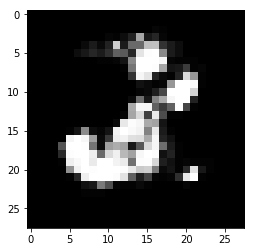

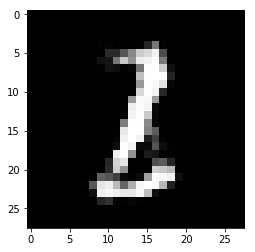

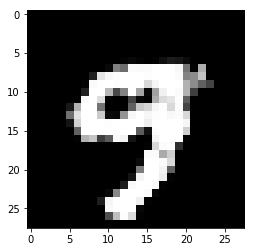

0.641131 2.04902
0.811427 1.47662
0.567911 1.90229
0.66433 1.86603
0.695743 2.02983


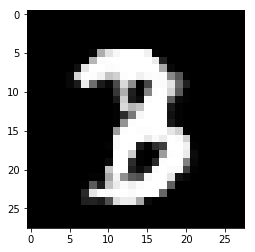

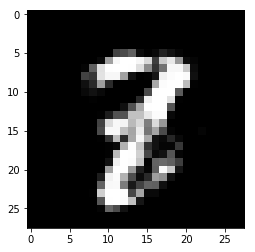

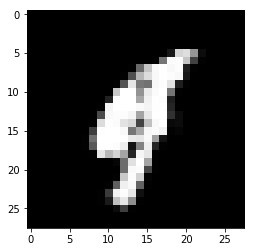

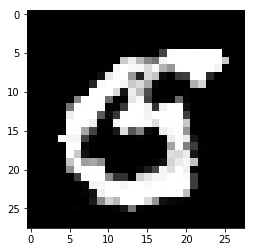

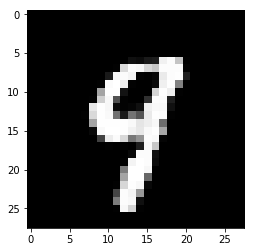

0.683433 2.07096
0.567731 2.2017
0.598167 2.06162
0.646589 2.37742
0.765049 2.15403


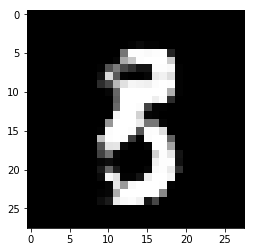

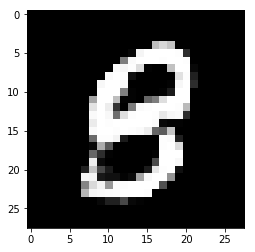

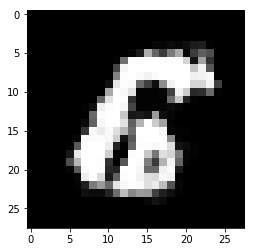

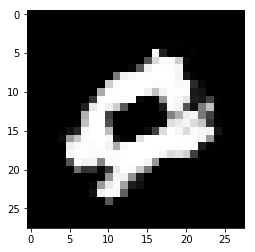

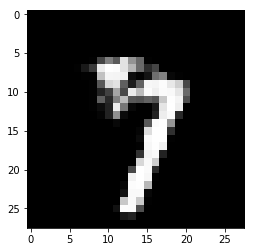

0.519945 2.15434
0.582334 2.38024
0.610104 2.47998
0.620669 2.08027
0.567822 2.12924


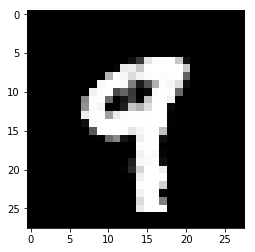

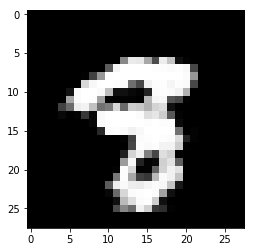

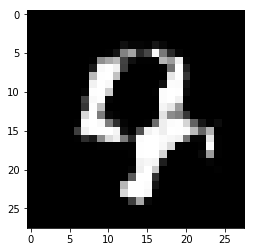

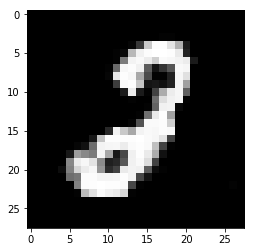

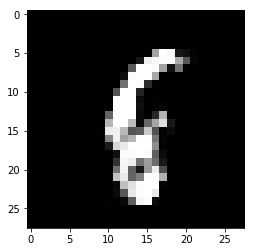

0.554301 2.38128
0.627139 2.53992
0.697263 2.22485
0.600469 2.507
0.593745 1.96006


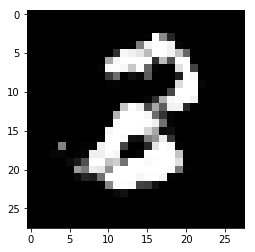

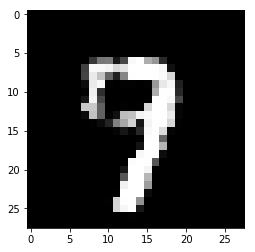

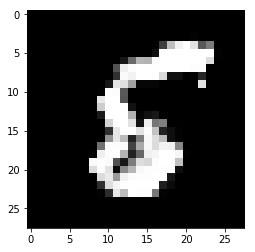

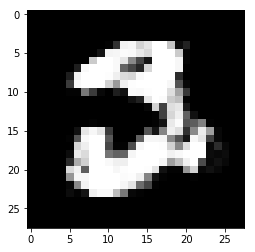

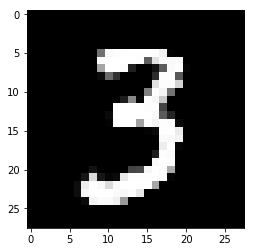

0.638133 2.06898
0.656416 2.14989
0.627429 2.13219
0.582499 2.0905
0.689469 2.43692


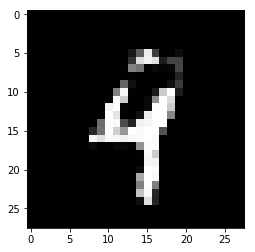

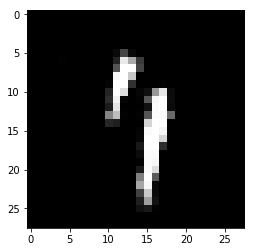

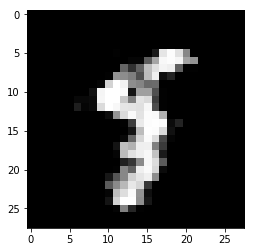

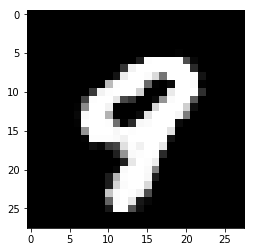

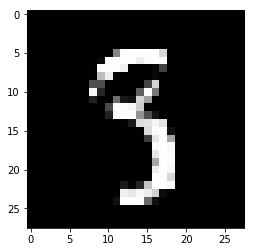

0.626666 2.14721
0.736723 1.83815
0.58793 2.37181
0.609554 2.37084
0.611172 2.44659


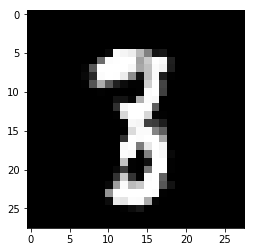

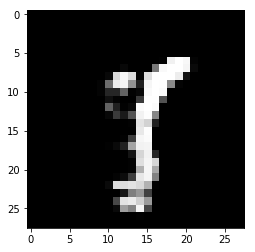

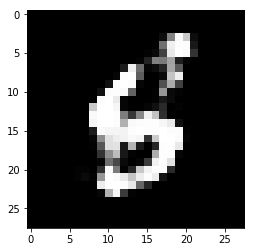

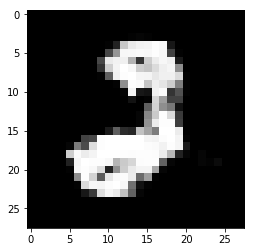

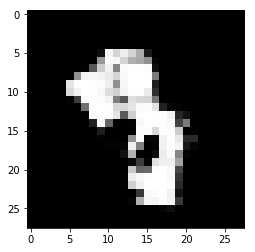

0.642192 2.29514
0.623555 2.53795
0.694412 2.21046
0.456361 2.69308
0.55598 2.5296


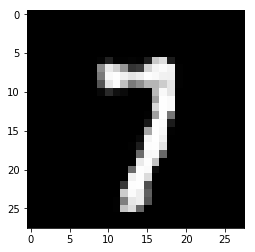

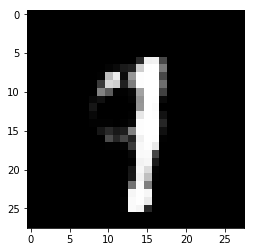

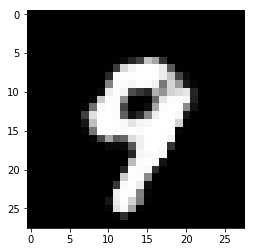

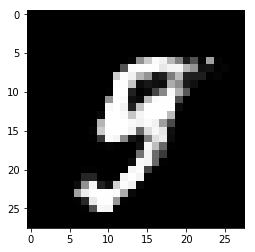

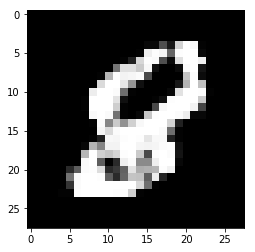

0.592412 2.66224
0.568354 2.10288
0.770077 2.17596
0.633072 2.05648
0.684181 2.13976


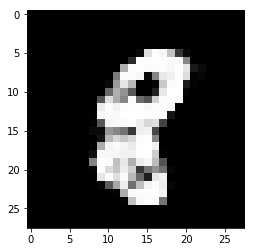

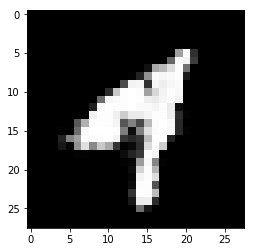

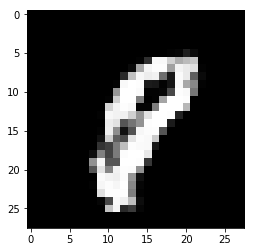

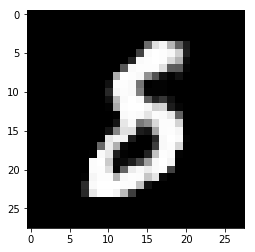

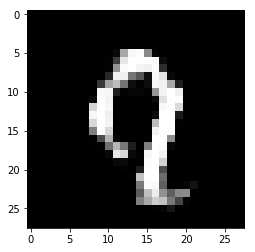

0.506764 2.082
0.585494 2.49133
0.557339 2.1446
0.652107 2.32078
0.465948 2.75521


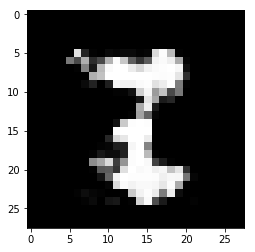

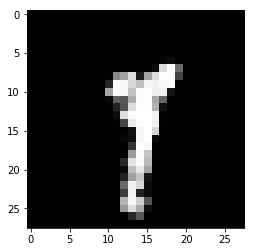

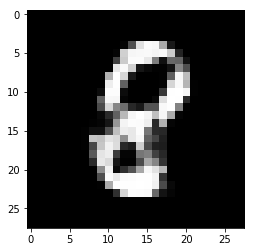

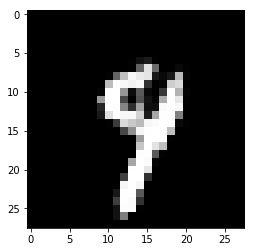

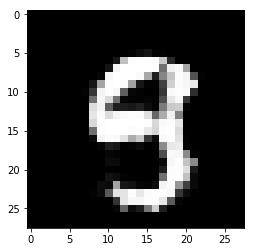

0.588214 2.09344
0.563747 2.31496
0.800705 2.32218
0.627014 2.52158
0.565055 2.14787


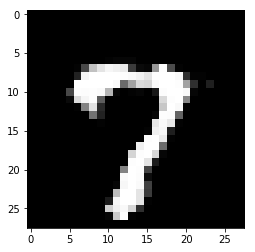

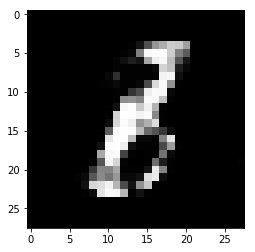

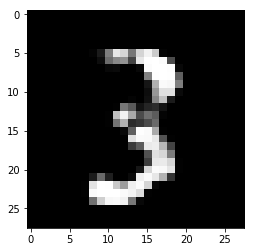

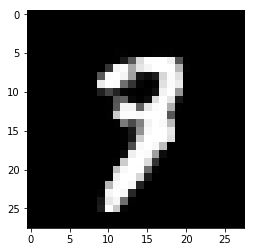

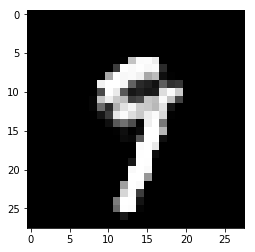

0.384158 2.72508
0.438557 2.44943
0.880144 2.17559
0.588641 2.385
0.488275 2.60363


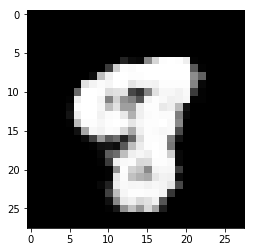

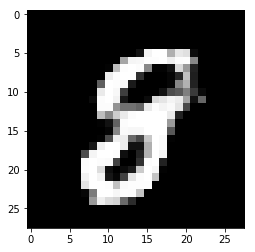

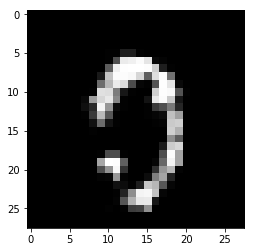

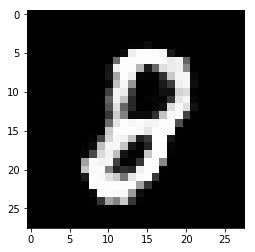

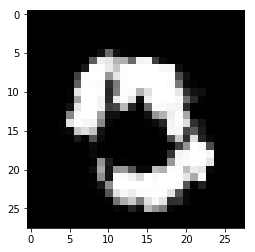

0.62187 2.34001
0.569813 2.37644
0.635991 2.4391
0.509145 2.63706
0.728827 2.17022


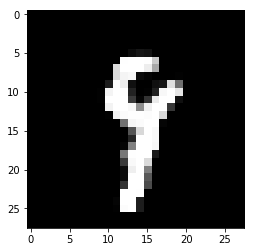

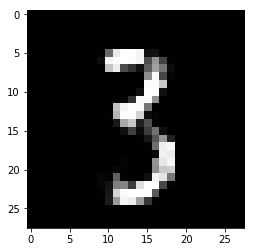

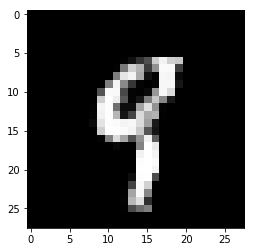

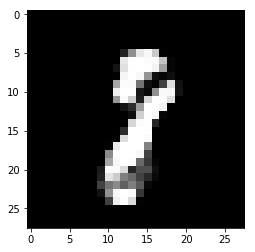

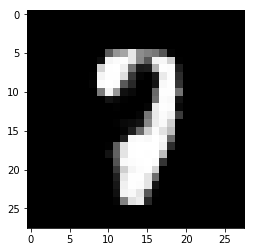

0.501976 2.91942
0.549349 2.36102
0.63436 2.62164
0.764651 2.07067
0.511347 2.39268


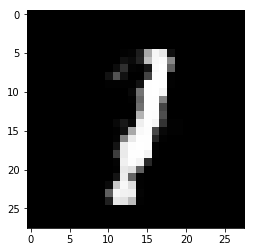

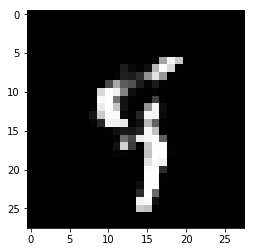

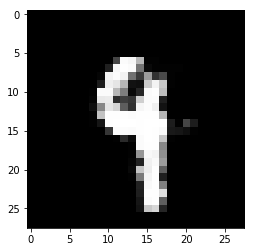

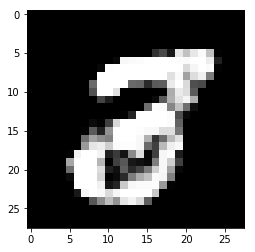

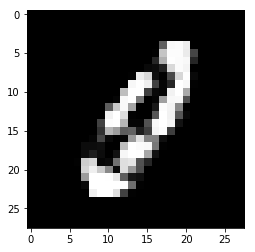

0.513283 2.2875
0.711858 2.22159
0.594409 2.12926
0.54281 2.65785
0.611599 2.38068


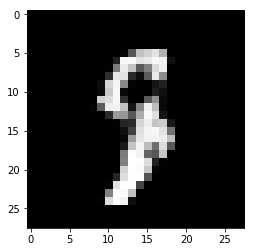

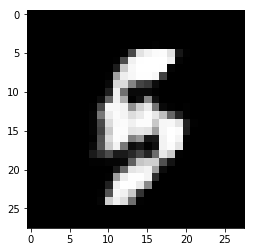

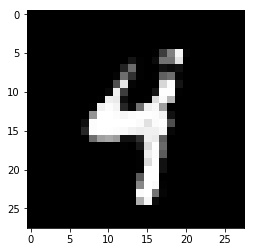

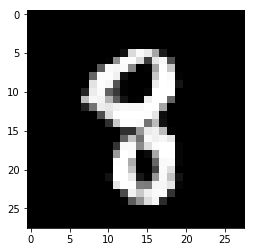

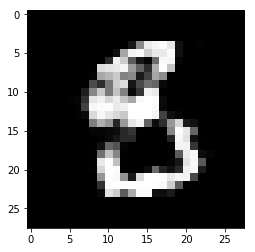

0.492909 2.15956
0.420677 2.67818
0.5649 2.08722
0.573348 2.09202
0.449717 2.46196


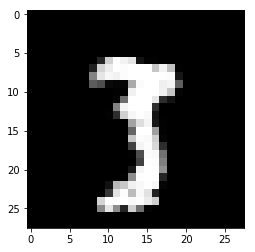

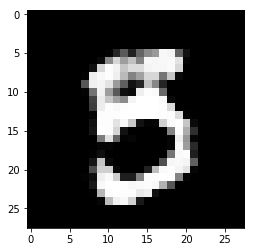

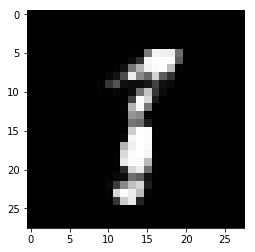

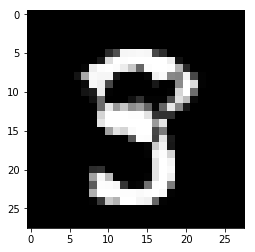

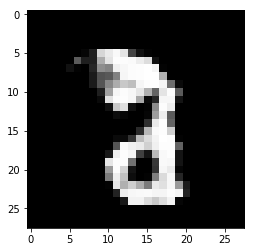

0.617359 2.3991
0.612674 2.39261
0.454047 2.37226
0.564093 2.25365
0.556254 2.42274


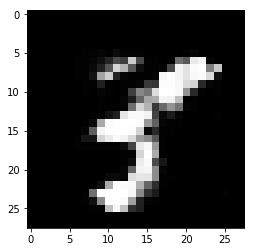

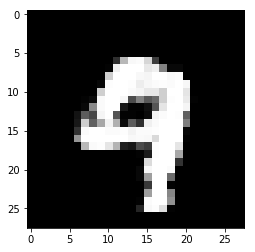

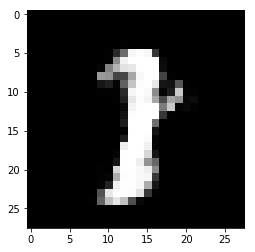

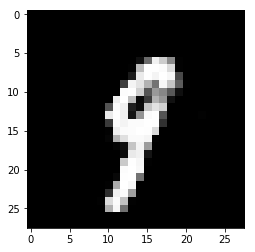

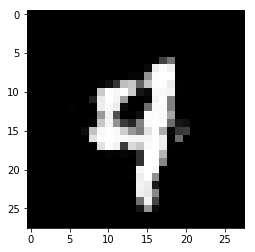

0.552221 2.06054
0.591363 2.22236
0.604832 2.50046
0.656006 2.17941
0.644662 2.31845


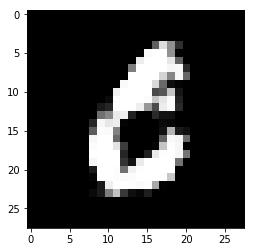

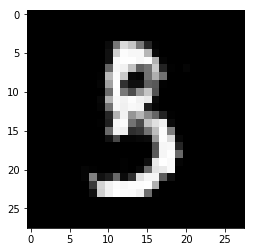

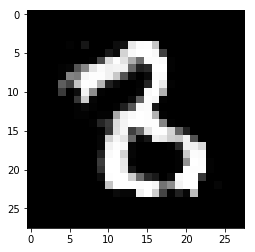

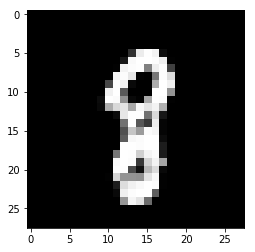

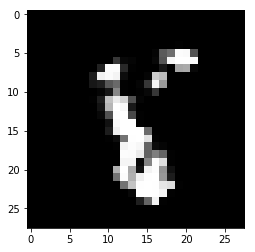

0.831481 2.10972
0.504963 2.50665
0.539267 2.06246
0.723789 2.25139
0.589509 2.31194


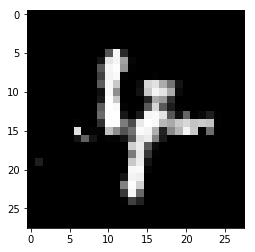

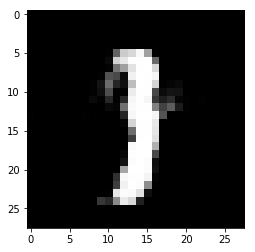

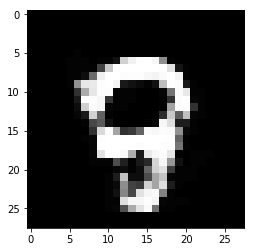

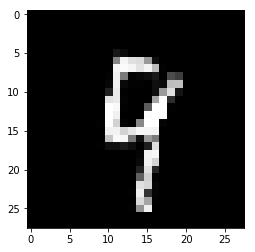

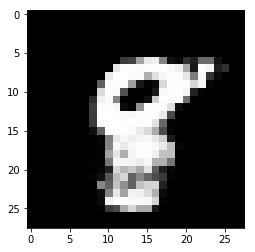

0.694798 2.42564
0.570131 2.54169
0.538688 2.14945
0.594971 2.4564
0.468686 2.9261


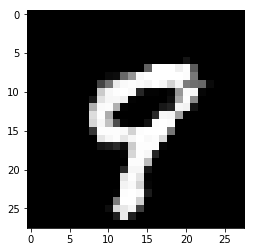

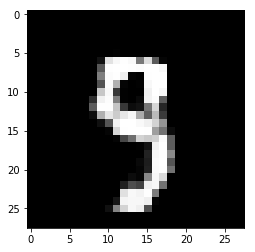

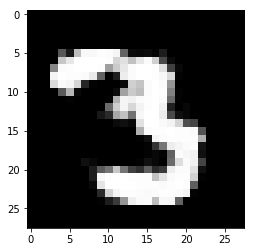

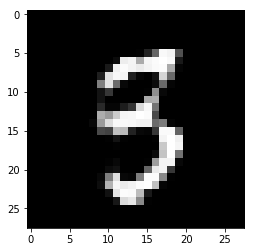

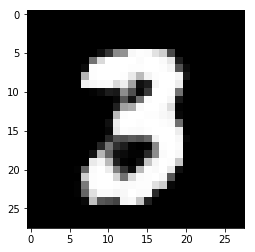

0.74631 2.30473
0.489156 2.65805
0.457528 2.68849
0.508849 2.30461
0.647244 2.36689


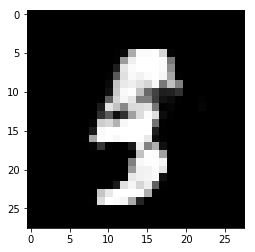

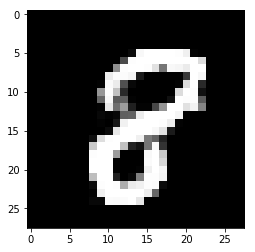

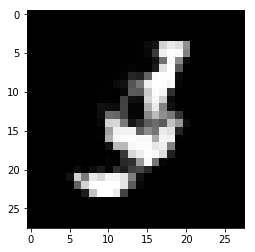

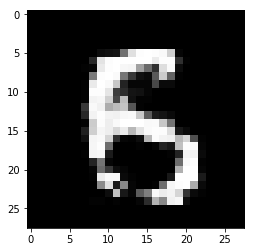

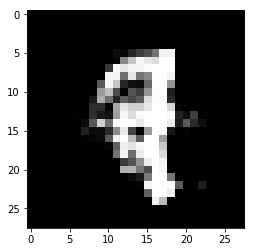

0.584497 2.52514
0.621703 2.26004
0.446166 2.42364
0.616581 2.28497
0.535732 2.11336


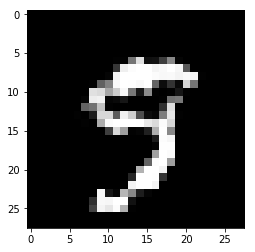

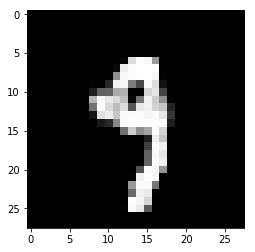

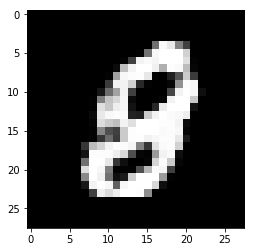

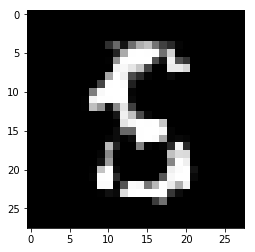

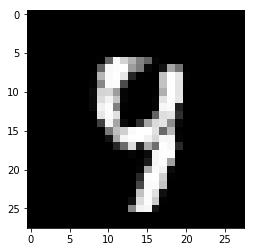

0.71908 2.22513
0.570136 2.41545
0.581983 2.27486
0.634924 2.45684
0.662766 2.35175


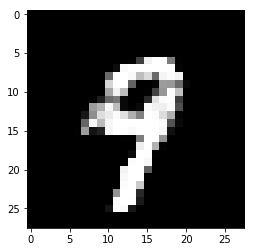

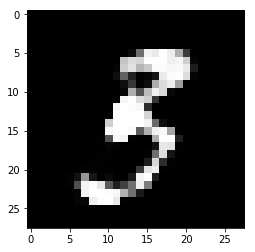

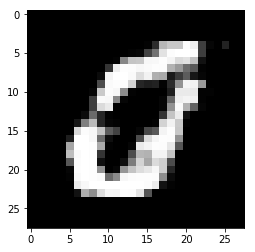

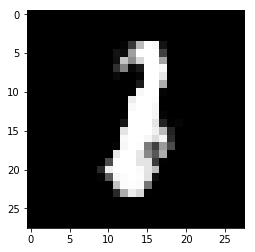

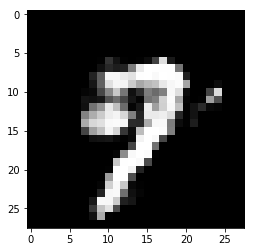

0.406693 2.44136
0.674565 2.07667
0.659385 2.56996
0.703195 1.85043
0.433905 2.40939


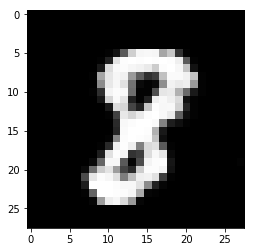

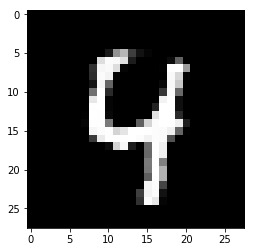

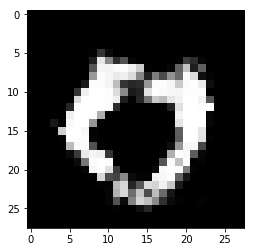

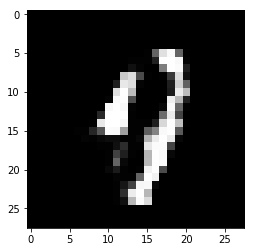

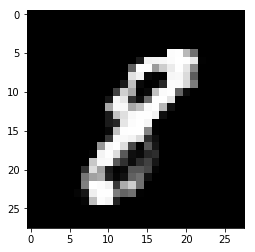

0.583048 2.50123
0.562169 2.43091
0.594718 2.52785
0.744758 2.17523
0.496852 2.66316


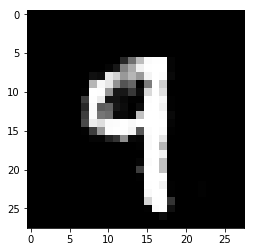

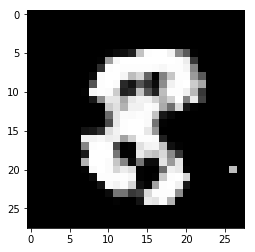

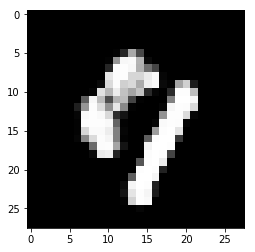

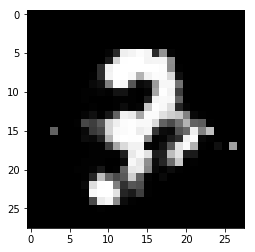

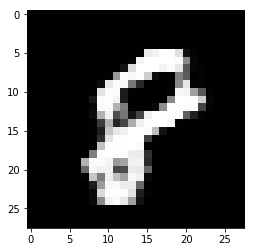

KeyboardInterrupt: 

In [11]:
d_step = 1
g_step = 2

for epoch in range(n_epoch):
    for i in range(n_sample / batch_size):
        X_train, y_train = mnist.train.next_batch(batch_size)
        X_train = X_train.reshape((-1, 28, 28, 1))
        noise = sampler((batch_size, z_dim))
        
        for i in range(d_step):
            _, d_loss_out = sess.run([d_optim, d_loss], feed_dict={xs:X_train, zs:noise})
            
        for i in range(g_step):
            _, g_loss_out = sess.run([g_optim, g_loss], feed_dict={zs:noise})
        
    print  d_loss_out, g_loss_out
    if epoch % 5 == 0:
        #save_image(G, epoch)
        show_image(G)